Fully Supervised BER

In [ ]:
!pip install transformers==3.0.0

     |████████████████████████████████| 757kB 9.0MB/s 
     |████████████████████████████████| 3.0MB 17.8MB/s 
     |████████████████████████████████| 901kB 49.8MB/s 
     |████████████████████████████████| 1.2MB 52.9MB/s 


In [ ]:
import torch

if torch.cuda.is_available():     
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Mounting Failed.")

Mounted at /content/drive


## Load the data

In [ ]:
import pandas as pd
df = pd.read_csv('drive/My Drive/DL-Final-Project/Dataset/FINAL_DATASET_NOHASHTAGS.csv',  lineterminator='\n')


In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

## Changes labels to 0 and 1

In [ ]:
tweets = df.Tweets.values
labels = df.Labels.values
labels[labels==-1] = 0

In [ ]:
import numpy as np
print(labels.mean())
freq = np.array(labels)
freq
zeros = np.where(freq == 0, 1, 0)
zeros = zeros.sum()
ones = np.where(freq == 1, 1, 0)
ones = ones.sum()

0.788147098754501


In [ ]:
max_len = 0

# For every sentence...
for tweet in tweets:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  40


## Tokenize the data (takes a while so don't be concerned)

In [ ]:
import torch
input_ids = []
attention_masks = []

# For every sentence...
for tweet in tweets:
    
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 50,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

Streaming output truncated to the last 5000 lines.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to

Original:  rt lolpacorg why do we let the 1 control guns too please rt to show support for safe gun laws http t co qp
Token IDs: tensor([  101, 19387,  8840, 14277, 22684, 10623,  2339,  2079,  2057,  2292,
         1996,  1015,  2491,  4409,  2205,  3531, 19387,  2000,  2265,  2490,
         2005,  3647,  3282,  4277,  8299,  1056,  2522,  1053,  2361,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calculate the number of samples to include in each set.
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

7,806 training samples
2,230 validation samples
1,116 test samples


In [ ]:
torch.save(train_dataset, 'drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/train_tokenized.pt')
torch.save(valid_dataset, 'drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/valid_tokenized.pt')
torch.save(test_dataset, 'drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/test_tokenized.pt')

# Load Saved Datasets 

In [ ]:
train_dataset = torch.load('drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/train_tokenized.pt')
val_dataset = torch.load('drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/valid_tokenized.pt')
test_dataset = torch.load('drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/test_tokenized.pt')

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np
import torch.nn as nn

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
weight = torch.tensor([zeros, ones])
weight = weight / torch.sum(weight)
weight = 1 / weight
weight = weight / torch.sum(weight)
weight = weight.unsqueeze(0)
loss_fn = nn.CrossEntropyLoss(weight = weight.to(device))
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        

        (___, logits) = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        #print(logits)
        loss = loss_fn(logits, b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        #scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
       
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
          (__, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = loss_fn(logits, b_labels)  
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    371.    Elapsed: 0:00:11.
  Batch    80  of    371.    Elapsed: 0:00:23.
  Batch   120  of    371.    Elapsed: 0:00:34.
  Batch   160  of    371.    Elapsed: 0:00:45.
  Batch   200  of    371.    Elapsed: 0:00:57.
  Batch   240  of    371.    Elapsed: 0:01:08.
  Batch   280  of    371.    Elapsed: 0:01:20.
  Batch   320  of    371.    Elapsed: 0:01:31.
  Batch   360  of    371.    Elapsed: 0:01:43.

  Average training loss: 0.37
  Training epcoh took: 0:01:46

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.27
  Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    371.    Elapsed: 0:00:12.
  Batch    80  of    371.    Elapsed: 0:00:23.
  Batch   120  of    371.    Elapsed: 0:00:35.
  Batch   160  of    371.    Elapsed: 0:00:47.
  Batch   200  of    371.    Elapsed: 0:00:59.
  Batch   240  of    371.    Elapsed: 0:01:10.
  Batch   280  of    371.    Elapsed: 0:01:22.
  Batch  

# Evaluate

In [ ]:
model.eval()

# Tracking variables 
total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0
labels = []
predictions = []
# Evaluate data for one epoch
for batch in test_dataloader:
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():        
      output = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
    logits = output[1]
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    pred_flat = np.argmax(logits, axis=1).flatten()
    predictions = np.concatenate((predictions, pred_flat))
    labels = np.concatenate((labels, label_ids))

In [ ]:
from sklearn.metrics import confusion_matrix
cfs = confusion_matrix(labels, predictions)

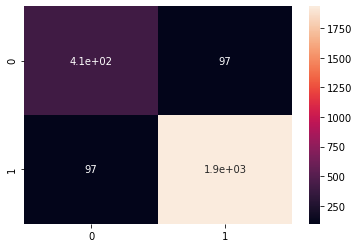

In [ ]:
import seaborn as sns
sns.heatmap(cfs, annot=True)

# Classification Report

In [ ]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.81      0.81      0.81       509
     class 1       0.95      0.95      0.95      2033

    accuracy                           0.92      2542
   macro avg       0.88      0.88      0.88      2542
weighted avg       0.92      0.92      0.92      2542



In [ ]:
torch.save(model, 'drive/My Drive/DL-Final-Project/Models/BERT_Supervised.pt')

# Testing Different Amounts of Training Data

In [ ]:
import random
import numpy as np
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
batch_size = 32
final_accuracies = []
proportions = [0.4, 0.6, 0.8]
dataset = torch.load('drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/train_tokenized.pt')
val_dataset = torch.load('drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/valid_tokenized.pt')
test_dataset = torch.load('drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/test_tokenized.pt')
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
weight = torch.tensor([zeros, ones])
weight = weight / torch.sum(weight)
weight = 1 / weight
weight = weight / torch.sum(weight)
weight = weight.unsqueeze(0)
loss_fn = nn.CrossEntropyLoss(weight = weight.to(device))
#loss_fn = nn.CrossEntropyLoss(weight = torch.tensor([1/zeros, 1/ones]).float().to(device))
training_stats = []
total_t0 = time.time()
from transformers import get_linear_schedule_with_warmup


for p in proportions:
  print(p)
  train_size = int(p * len(dataset))
  throw_size = len(dataset) - train_size
  train_dataset, throwaway = random_split(dataset, [train_size, throw_size])
  train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
  validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

  test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
  
  model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
  )
  model.cuda()
  optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
  epochs = 4
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
  


  for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        

        (___, logits) = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        #print(logits)
        loss = loss_fn(logits, b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        #scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in test_dataloader:
       
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
          (__, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = loss_fn(logits, b_labels)  
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
  final_accuracies.append(avg_val_accuracy)  

0.4


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    149.    Elapsed: 0:00:11.
  Batch    80  of    149.    Elapsed: 0:00:22.
  Batch   120  of    149.    Elapsed: 0:00:33.

  Average training loss: 0.45
  Training epcoh took: 0:00:41

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.32
  Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    149.    Elapsed: 0:00:11.
  Batch    80  of    149.    Elapsed: 0:00:23.
  Batch   120  of    149.    Elapsed: 0:00:35.

  Average training loss: 0.27
  Training epcoh took: 0:00:43

Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.33
  Validation took: 0:00:08

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    149.    Elapsed: 0:00:13.
  Batch    80  of    149.    Elapsed: 0:00:25.
  Batch   120  of    149.    Elapsed: 0:00:37.

  Average training loss: 0.15
  Training epcoh took: 0:00:45

Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.37
  Validation too

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    223.    Elapsed: 0:00:12.
  Batch    80  of    223.    Elapsed: 0:00:24.
  Batch   120  of    223.    Elapsed: 0:00:36.
  Batch   160  of    223.    Elapsed: 0:00:49.
  Batch   200  of    223.    Elapsed: 0:01:01.

  Average training loss: 0.41
  Training epcoh took: 0:01:08

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.29
  Validation took: 0:00:08

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    223.    Elapsed: 0:00:12.
  Batch    80  of    223.    Elapsed: 0:00:24.
  Batch   120  of    223.    Elapsed: 0:00:36.
  Batch   160  of    223.    Elapsed: 0:00:48.
  Batch   200  of    223.    Elapsed: 0:01:01.

  Average training loss: 0.25
  Training epcoh took: 0:01:07

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.27
  Validation took: 0:00:08

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    223.    Elapsed: 0:00:12.
  Batch    80  of    223.    Elapsed: 0:00:24.
 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    297.    Elapsed: 0:00:12.
  Batch    80  of    297.    Elapsed: 0:00:24.
  Batch   120  of    297.    Elapsed: 0:00:36.
  Batch   160  of    297.    Elapsed: 0:00:49.
  Batch   200  of    297.    Elapsed: 0:01:01.
  Batch   240  of    297.    Elapsed: 0:01:13.
  Batch   280  of    297.    Elapsed: 0:01:25.

  Average training loss: 0.39
  Training epcoh took: 0:01:30

Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.27
  Validation took: 0:00:08

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    297.    Elapsed: 0:00:12.
  Batch    80  of    297.    Elapsed: 0:00:24.
  Batch   120  of    297.    Elapsed: 0:00:36.
  Batch   160  of    297.    Elapsed: 0:00:49.
  Batch   200  of    297.    Elapsed: 0:01:01.
  Batch   240  of    297.    Elapsed: 0:01:13.
  Batch   280  of    297.    Elapsed: 0:01:25.

  Average training loss: 0.23
  Training epcoh took: 0:01:30

Running Validation...
  Accuracy: 0.92
 

In [ ]:
final_accuracies

[0.9091517857142858, 0.9096540178571428, 0.926171875]

In [ ]:
model.eval()

# Tracking variables 
total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0
labels = []
predictions = []
# Evaluate data for one epoch
for batch in test_dataloader:
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():        
      output = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
    logits = output[1]
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    pred_flat = np.argmax(logits, axis=1).flatten()
    predictions = np.concatenate((predictions, pred_flat))
    labels = np.concatenate((labels, label_ids))

In [ ]:
from sklearn.metrics import confusion_matrix
cfs = confusion_matrix(labels, predictions)

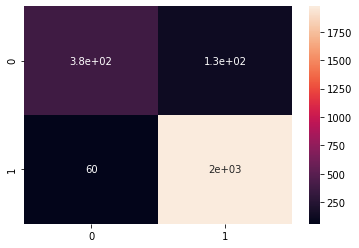

In [ ]:
import seaborn as sns
sns.heatmap(cfs, annot=True)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.86      0.75      0.80       509
     class 1       0.94      0.97      0.95      2033

    accuracy                           0.93      2542
   macro avg       0.90      0.86      0.88      2542
weighted avg       0.92      0.93      0.92      2542



In [ ]:
torch.save(model, 'drive/My Drive/DL-Final-Project/Models/BERT_Supervised_5_5.pt')

# Run All Evaluations on Smallest Train Set

In [ ]:
import random
import numpy as np
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
batch_size = 32
final_accuracies = []
proportions = [0.2]
dataset = torch.load('drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/train_tokenized.pt')
val_dataset = torch.load('drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/valid_tokenized.pt')
test_dataset = torch.load('drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/test_tokenized.pt')
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
loss_fn = nn.CrossEntropyLoss(weight = torch.tensor([1/zeros, 1/ones]).float().to(device))
training_stats = []
total_t0 = time.time()
from transformers import get_linear_schedule_with_warmup


for p in proportions:
  print(p)
  train_size = int(p * len(dataset))
  throw_size = len(dataset) - train_size
  train_dataset, throwaway = random_split(dataset, [train_size, throw_size])
  train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
  validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

  test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
  
  model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
  )
  model.cuda()
  optimizer = AdamW(model.parameters(),
                  lr = 3e-6, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
  epochs = 10
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
  


  for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        

        (___, logits) = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        #print(logits)
        loss = loss_fn(logits, b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        #scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in test_dataloader:
       
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
          (__, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = loss_fn(logits, b_labels)  
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))


  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Valid. Loss': avg_val_loss,
          'Valid. Accur.': avg_val_accuracy,
          'Training Time': training_time,
          'Validation Time': validation_time
      }
  )

  final_accuracies.append(avg_val_accuracy)  

0.2


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 10 ========
Training...
  Batch    40  of     75.    Elapsed: 0:00:11.

  Average training loss: 0.62
  Training epcoh took: 0:00:21

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.53
  Validation took: 0:00:07

======== Epoch 2 / 10 ========
Training...
  Batch    40  of     75.    Elapsed: 0:00:11.

  Average training loss: 0.50
  Training epcoh took: 0:00:21

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.47
  Validation took: 0:00:07

======== Epoch 3 / 10 ========
Training...
  Batch    40  of     75.    Elapsed: 0:00:12.

  Average training loss: 0.43
  Training epcoh took: 0:00:22

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.44
  Validation took: 0:00:07

======== Epoch 4 / 10 ========
Training...
  Batch    40  of     75.    Elapsed: 0:00:12.

  Average training loss: 0.38
  Training epcoh took: 0:00:22

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.44
  Validation took: 0:00:07

======== Epoch 5 / 10 =

In [ ]:
model.eval()

# Tracking variables 
total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0
labels = []
predictions = []
# Evaluate data for one epoch
for batch in test_dataloader:
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():        
      output = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
    logits = output[1]
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    pred_flat = np.argmax(logits, axis=1).flatten()
    predictions = np.concatenate((predictions, pred_flat))
    labels = np.concatenate((labels, label_ids))

In [ ]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.73      0.69      0.71       509
     class 1       0.92      0.94      0.93      2033

    accuracy                           0.89      2542
   macro avg       0.83      0.81      0.82      2542
weighted avg       0.88      0.89      0.89      2542

